# Deep Learning & Geophysical Dynamics
## Project - short-term wind forecasting

In this notebook, a deep learning project is proposed based on the open source weather dataset from Météo France : MétéoNet. 
https://meteonet.umr-cnrm.fr/

The dataset comprises 3 years of weather data with different data sources : 
- Ground stations observations
- 2D and 3D Numercial Weather Predictions (AROME, ARPEGE)
- Rain radar data
- Satellite date : optical, infrared, cloud type

In this project we will focus on the ultra short-term forecasting of wind time series on the northwestern corner of France. The question we will try to answer is : how to complement Numerical Weather Prediction (NWP) on ultra short time scales (<3h) using Deep Learning ? 

Compared to NWP, deep learning models, once trained, can infer forecasts very quickly, and in this regard, could complement NWP in terms of forecast update frequency and data assimilation time scale. This aspect finds important applications in the wind energy industry, for wind power prediction forecasting, market participation optimization, operations and maintenance safety and weather windows optimization (at sea). 

## 1. Download data and inspect data samples

This is a prepared sample of the whole dataset. More data can be obtained at https://meteonet.umr-cnrm.fr/dataset/.

#### Ground stations observations
##### Metadata parameters

- number_sta : ground station number

- lat : latitude into decimal degrees

- lon : longitude into decimal degrees

- height_sta : station height into meters

The date parameter is a datetime object with the format 'YYYY-MM-DD HH:mm:ss'.



##### Meteorological parameters

- dd : wind direction in degrees

- ff : wind speed in m.s-1

- precip : precipitation during the reporting period in kg.m2

- hu : humidity in %

- td : dew point temperature** in Kelvin

- t : temperature in Kelvin

- psl : pressure reduced to sea level in Pa

In [2]:
import pandas as pd
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def read_meteonet_ground_stations(year, minlat=40, maxlat=45, minlon=0, maxlon=10):
    path = 'C://Users/rmarcill/Documents/FEM/FLOWTOM/Data/MeteoNet/ground_stations/SE/'
    filename = path + 'SE' + year + '.csv'
    chunksize = 500000
    final_df = []
    with pd.read_csv(filename, chunksize=chunksize) as reader:
        for chunk in reader:
            final_df.append(chunk[(chunk.lat <= maxlat)&(chunk.lat >= minlat)&(chunk.lon >= minlon)&(chunk.lon <= maxlon)])
    df_gs = pd.DataFrame()
    for df in final_df :
        df_gs = pd.concat([df_gs, df], join = 'outer', ignore_index = True)
    return df_gs

In [4]:
year = '2016'
df_gs = read_meteonet_ground_stations(year)

In [5]:
display(df_gs.head())

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,4006005,44.24,6.630,1400.0,20160101 00:00,NaN,NaN,0.0,NaN,NaN,272.55,NaN
1,4019001,44.39,6.670,1155.0,20160101 00:00,0.0,0.0,0.0,88.0,271.35,273.15,NaN
2,4049001,44.06,5.990,461.0,20160101 00:00,80.0,0.8,0.0,83.0,276.05,278.75,102660.0
3,4068001,43.91,5.770,427.0,20160101 00:00,0.0,0.0,0.0,96.0,277.85,278.45,NaN
4,4070009,44.07,6.187,554.0,20160101 00:00,30.0,1.2,0.0,88.0,276.55,278.35,NaN


Not all the stations measure all the parameters, let's visualize the stations and their measured parameters

In [6]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Let's pivot the table around the ground stations number

In [7]:
df_sta = pd.pivot_table(df_gs, index ='number_sta', aggfunc = 'mean')
display(df_sta.head())
df_sta['valid'] = (~df_sta.isna()).sum(axis = 1) -2

,dd,ff,height_sta,hu,lat,lon,precip,psl,t,td
number_sta,,,,,,,,,,
4006005,NaN,NaN,1400.0,NaN,44.240000,6.630,0.012725,NaN,280.583733,NaN
4019001,117.701816,1.199716,1155.0,71.356155,44.390374,6.670,0.009220,NaN,280.685473,274.548734
4049001,133.519710,3.249089,461.0,63.147818,44.060000,5.990,0.007840,101639.075507,286.311386,278.471934
4068001,170.725828,2.574726,427.0,69.410553,43.910000,5.770,0.007711,NaN,285.724541,279.169823
4070009,163.992088,1.837492,554.0,68.074311,44.070000,6.187,0.007975,NaN,284.912711,278.172074


<IPython.core.display.Javascript object>


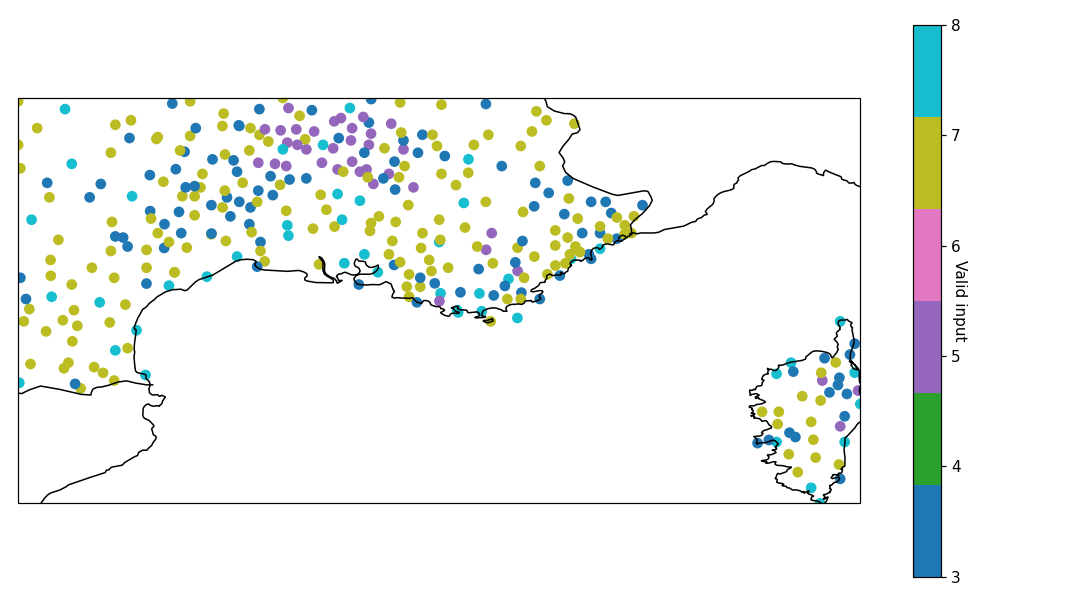

In [8]:
lllon, lllat = df_gs.lon.min(), df_gs.lat.min()
urlon, urlat = df_gs.lon.max(), df_gs.lat.max()
extent = [lllon, urlon, lllat, urlat]
fig = plt.figure(figsize=(9,5))

# Select projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data, color per valid data
cmap = plt.get_cmap('tab10', 6)
plt.scatter(df_sta['lon'], df_sta['lat'], c=df_sta.valid, cmap=cmap) 

# Add coastlines and borders
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

# Show only the area we defined
ax.set_extent(extent)
cbar = plt.colorbar()
cbar.set_label('Valid input', rotation = 270)
plt.show()
plt.tight_layout()

#### Weather models - 2D parameters

There are two weather models in the MeteoNet dataset : 
- A fine mesh weather model (AROME, resolution = 0.025°)
- A large mesh weatehr model (ARPEGE, resolution of 0.1°)
These models are operationnaly issued every 6 hours, with predictions up to 48h for AROME and 114h for ARPEGE. They both have a resolution of 1h. 
In this dataset, only the forecast issued at midnight are present, i.e. 1 forecast from 00:00 to 24:00 every day. 
The data is stored in four different folders for each model: 
- at 2m (2m in the file name) : temperature (in K), dew point temperature** (in K) and relative humidity (in %)
- at 10m (10m in the file name): wind speed (in m.s-1), wind direction (in degrees), U and V wind components*** (in m.s-1)
- at the sea level (P_sea_level in the file name) : mean sea level pressure (in Pa)
- at the ground level (PRECIP in the file name) : total precipitation (in kg m-2 which is equivalent to mm) since the beginning of the model run

Data is stored in a grib file, so you'll need to install the ecmwf cfgrib library to be able to read data with the xarray library and engine 'cfgrib'
you can conda or pip install cfgrib and xarray :

$ conda install -c conda-forge cfgrib

$ pip install cfgrib

$ conda install -c anaconda xarray

$ pip install cfgrib

For the proposed project, we're going to focus on the AROME data, on a smaller area and only considering wind speed at 10m, pressure, temperature and relative humidity.

In [9]:
import xarray as xr
import datetime as dt

Here is the piece of code to read grib files

In [38]:
model = 'AROME'
level = '10m'
month = '01'
day = '01'
year = '2016'
gribfile = model.lower() + '_' + level +'_' + 'NW' + '_' + year + month + day + '000000.grib'
fname = 'C://Users/rmarcill/Documents/FEM/FLOWTOM/Data/MeteoNet/data_samples/NW/models/NW_weather_models_2D_parameters_2016/' + year + month + '/' + model + '/' + level +'/' + gribfile
ds_arome = xr.open_dataset(fname, engine='cfgrib', backend_kwargs={"indexpath" : ""})

Now let's read the prepared sliced files (netcdf4 format). The five parameters of interest are extracted and put in a single netcdf4 file.

In [24]:
def read_meteonet_model_netcdf(years, months, minlat = 0, maxlat = 50, minlon = 0, maxlon = 10):
    for i, year in tqdm(enumerate(years)):
        for j, month in enumerate(months):
            path = 'C://Users/rmarcill/Documents/FEM/FLOWTOM/Data/MeteoNet/models/SE_2D_sub/'
            ds = xr.open_dataset(path + year + month + '_sliceDL.netcdf4', engine = 'netcdf4')
            mask_lat = (ds.latitude<maxlat)&(ds.latitude>minlat)
            mask_lon = (ds.longitude<maxlon)&(ds.longitude>minlon)
            ds = ds.where(mask_lat & mask_lon, drop = True)
            if (i==0) & (j==0):
                dsout = ds
            else :
                dsout = xr.concat([dsout, ds], dim = 'valid_time')
    return dsout

years = ['2016']
months = ['01']
ds_test = read_meteonet_model_netcdf(years, months)
display(ds_test)

1it [00:00,  2.32it/s]


<xarray.Dataset>
Dimensions:            (valid_time: 744, latitude: 120, longitude: 159)
Coordinates:
    time               (valid_time) datetime64[ns] ...
    step               (valid_time) timedelta64[ns] ...
    meanSea            float64 0.0
  * latitude           (latitude) float64 44.98 44.95 44.93 ... 42.05 42.03 42.0
  * longitude          (longitude) float64 4.025 4.05 4.075 ... 7.925 7.95 7.975
  * valid_time         (valid_time) datetime64[ns] 2016-01-01 ... 2016-01-31T...
    heightAboveGround  float64 10.0
Data variables:
    msl                (valid_time, latitude, longitude) float32 1.027e+05 .....
    u10                (valid_time, latitude, longitude) float32 -0.3504 ... ...
    v10                (valid_time, latitude, longitude) float32 0.1166 ... -...
    t2m                (valid_time, latitude, longitude) float32 276.3 ... 288.2
    r                  (valid_time, latitude, longitude) float32 100.0 ... 80.36
Attributes:
    GRIB_edition:            1
    GRIB_centre:             lfpw
    GRIB_centreDescription:  French Weather Service - Toulouse
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             French Weather Service - Toulouse
    history:                 2021-11-03T14:35 GRIB to CDM+CF via cfgrib-0.9.9...

In [17]:
lat_ar = ds_test.variables['latitude'].values
lon_ar = ds_test.variables['longitude'].values
timestep = ds_test.variables['valid_time'].values
msl = ds_test.variables['msl'].values
u10 = ds_test.variables['u10'].values
v10 = ds_test.variables['v10'].values
t2m = ds_test.variables['t2m'].values
r = ds_test.variables['r'].values

In [18]:
def plot_quiver(lon, lat , u, v):
    plt.figure()
    umag = np.sqrt(u**2 + v**2)
    XLON, YLAT = np.meshgrid(lon, lat)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = ax.contourf(XLON, YLAT, umag, levels = np.linspace(0, int(np.max(umag)) + 1, 100), zorder = 2)
    cbar = plt.colorbar(cs, ticks=np.arange(0, int(np.max(umag)) + 1, step = 1))
    cbar.set_label('Wind speed [m/s]', rotation = 270)
    lat = pd.DataFrame(lat).round(3)
    lon = pd.DataFrame(lon).round(3)
    minlon = lon.min()[0]
    minlat = lat.min()[0]
    maxlon = lon.max()[0]
    maxlat = lat.max()[0]
    Nlat = 0.2
    Nlon = 0.2
    dlat = np.arange(minlat, maxlat, Nlat).round(3)
    dlon = np.arange(minlon, maxlon, Nlon).round(3)
    locsx = pd.DataFrame(XLON.round(3)).isin(dlon)
    locsy = pd.DataFrame(YLAT.round(3)).isin(dlat)
    x = XLON[locsx&locsy]
    y = YLAT[locsx&locsy]
    Fx = u[locsx&locsy]
    Fy = v[locsx&locsy]
    umag = umag[locsx&locsy]
    ax.quiver(x, y, Fx, Fy, width=0.005, scale=10*np.max(umag), color = 'k', transform=ccrs.PlateCarree(), zorder = 4)
    plt.xlabel("Longitude", fontsize = 'x-large')
    plt.ylabel("Latitude", fontsize = 'x-large')
    plt.xlim((minlon,maxlon))
    plt.ylim((minlat, maxlat))
    ax.coastlines(zorder = 3)
    plt.xticks(np.arange(minlon, maxlon, step=1))
    plt.yticks(np.arange(minlat, maxlat, step=1))        

<IPython.core.display.Javascript object>


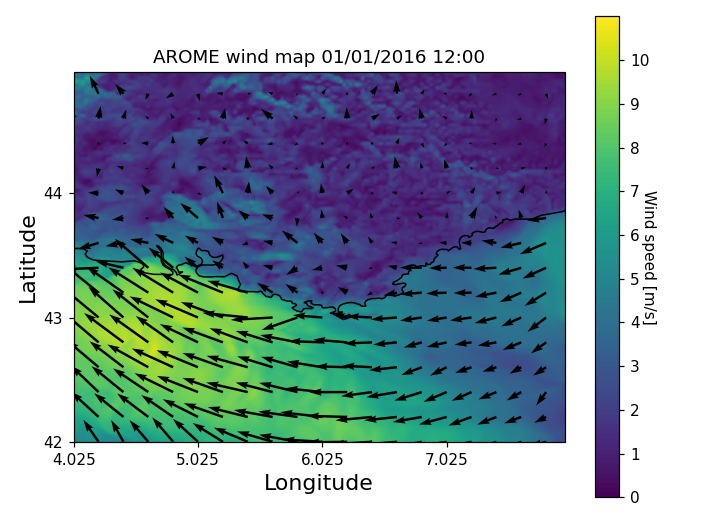

In [19]:
time_index = 12
day = '01'
plot_quiver(lon_ar, lat_ar, u10[time_index], v10[time_index])
plt.title('AROME wind map %s/%s/%s %s:00' %(day, month, year, time_index))
plt.tight_layout()

## 2. Data preparation

We're going to work on the South-Eastern corner of France, where meteorological phenomenons are hard to predict and with strong impact (heavy precipitation, sudden wind shifts). The dataset focuses on a smaller region than the original MeteoNet region. The goal will be to predict wind time series offshore from various input.

The proposed target weather station will be the station on Porquerolles island. Its offshore position makes it a particular site to predict, but feel free to take another station as target.

In [21]:
years = ['2016', '2017', '2018']
df_target_gs = pd.DataFrame()
minlat = 43
maxlat = 43.1
minlon = 6.1
maxlon = 6.3
for year in tqdm(years): 
    df_gs = read_meteonet_ground_stations(year, minlat = 43, maxlat = 43.1, minlon = 6.2, maxlon = 6.3)
    df_target_gs = pd.concat([df_target_gs,df_gs] , join = 'outer')

100%|██████████| 3/3 [02:09<00:00, 43.20s/it]


In [22]:
df_target_gs.index = pd.to_datetime(df_target_gs.date)
display(df_target_gs.head())

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
date,,,,,,,,,,,,
2016-01-01 00:00:00,83069002,43.0,6.23,137.0,20160101 00:00,60.0,3.5,0.0,85.0,281.35,283.75,NaN
2016-01-01 00:06:00,83069002,43.0,6.23,137.0,20160101 00:06,60.0,3.1,0.0,84.0,281.25,283.85,NaN
2016-01-01 00:12:00,83069002,43.0,6.23,137.0,20160101 00:12,60.0,3.5,0.0,84.0,281.25,283.85,NaN
2016-01-01 00:18:00,83069002,43.0,6.23,137.0,20160101 00:18,70.0,4.0,0.0,84.0,281.15,283.75,NaN
2016-01-01 00:24:00,83069002,43.0,6.23,137.0,20160101 00:24,60.0,4.0,0.0,83.0,280.95,283.75,NaN


In [25]:
lat_target = df_target_gs.lat.unique()[0]
lon_target = df_target_gs.lon.unique()[0]
minlat = lat_target - 0.0125
maxlat = lat_target + 0.0125
minlon = lon_target - 0.0125
maxlon = lon_target + 0.0125
years = ['2016']#, '2017', '2018']
months = ['01' , '02', '03' , '04', '05', '06' , '07', '08', '09', '10', '11', '12']
ds_target_model = read_meteonet_model_netcdf(years, months, minlat = minlat, maxlat = maxlat,minlon =  minlon,maxlon = maxlon)
display(ds_target_model)

1it [00:02,  2.69s/it]


<xarray.Dataset>
Dimensions:            (valid_time: 8760, latitude: 1, longitude: 1)
Coordinates:
    time               (valid_time) datetime64[ns] 2016-01-01 ... 2016-12-31
    step               (valid_time) timedelta64[ns] 00:00:00 ... 23:00:00
    meanSea            float64 0.0
  * latitude           (latitude) float64 43.0
  * longitude          (longitude) float64 6.225
  * valid_time         (valid_time) datetime64[ns] 2016-01-01 ... 2016-12-31T...
    heightAboveGround  float64 10.0
Data variables:
    msl                (valid_time, latitude, longitude) float32 1.026e+05 .....
    u10                (valid_time, latitude, longitude) float32 -1.968 ... 3...
    v10                (valid_time, latitude, longitude) float32 -0.9772 ... ...
    t2m                (valid_time, latitude, longitude) float32 284.7 ... 284.1
    r                  (valid_time, latitude, longitude) float32 83.94 ... 67.05
Attributes:
    GRIB_edition:            1
    GRIB_centre:             lfpw
    GRIB_centreDescription:  French Weather Service - Toulouse
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             French Weather Service - Toulouse
    history:                 2021-11-03T14:35 GRIB to CDM+CF via cfgrib-0.9.9...

<IPython.core.display.Javascript object>


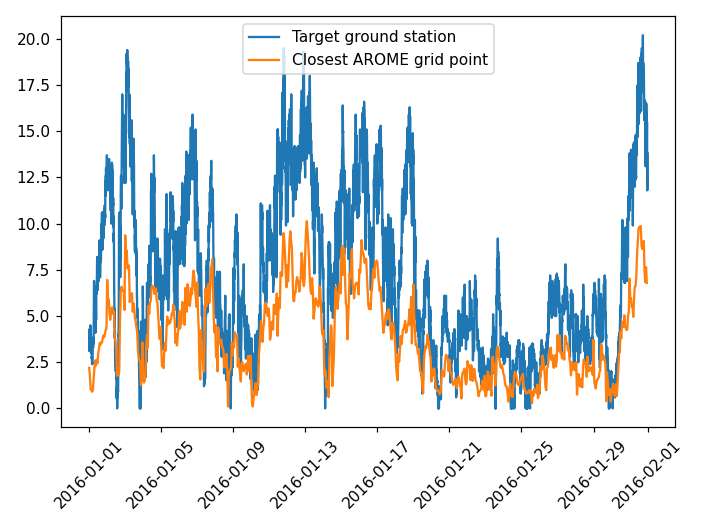

In [34]:
plt.figure()
plt.plot(df_target_gs[(df_target_gs.index.month == 1)&(df_target_gs.index.year == 2016)].index, df_target_gs[(df_target_gs.index.month == 1)&(df_target_gs.index.year == 2016)].ff, label = 'Target ground station')
plt.plot(ds_target_model.variables['valid_time'][:744], np.sqrt(ds_target_model.variables['u10'][:744, 0, 0]**2 + ds_target_model.variables['v10'][:744, 0, 0]**2), label = 'Closest AROME grid point')
plt.legend()
plt.xticks(rotation = 45)
plt.tight_layout()

# Task description

We will try to predict the wind time series at a target station using neighbouring weather stations and numerical weather prediction. The forecast can be performed using : 

- Historical values of the forecasted parameter
- Neighbouring weather stations data
- Numerical weather prediction models 

Feel free to add exogeneous data from the MeteoNet dataset (rain radar, satellite products). 

Compare de forecast accuracy to numerical weather prediction, corrected NWP, and benchmark persistence for time leads +6min - +6h. Be aware of the seasonality and temporal correlation of the data !

The proposed target station is on the Porquerolles island, feel free to score on various weather stations. 